In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

每个优化器构造函数都接收一个参数列表（又称 PyTorch 张量，通常将requires_grad 设置为True）作为第 1 个输入。传递给优化器的所有参数都保留在优化器对象中，这样优化器就可以更新它们的值并访问它们的 grad 属性，如图 5.11 所示。

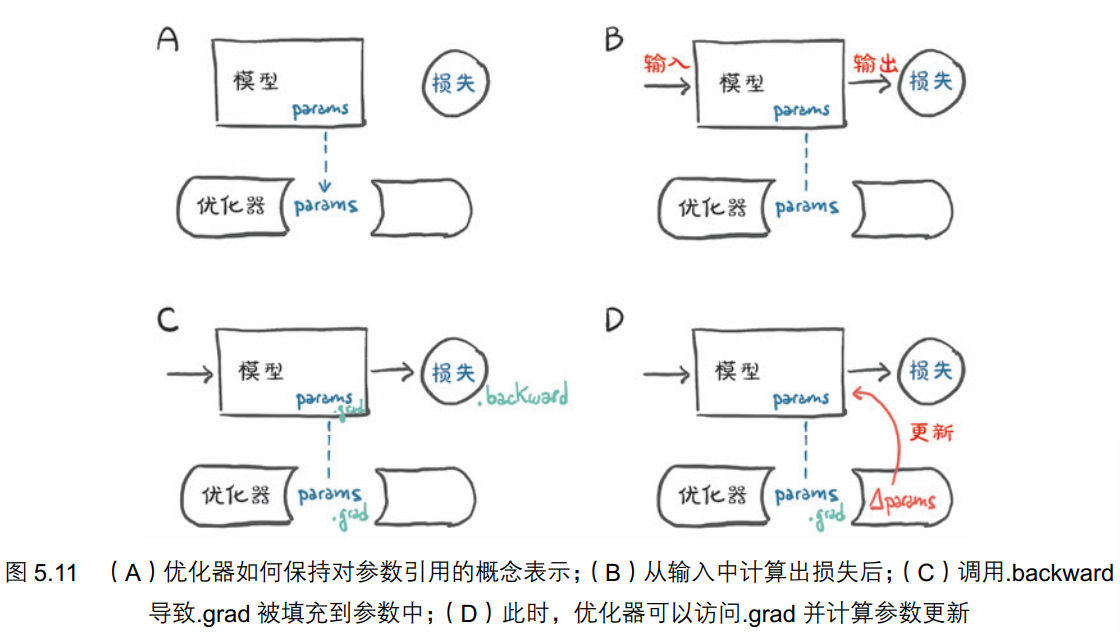

每个优化器公开 2 个方法： zero_grad()和 step.zero_grad()，在构造函数中将传递给优化器的所有参数的 grad 属性归零。 step()根据特定优化器实现的优化策略更新这些参数的值。

In [6]:
# 创建 params 张量并实例化一个梯度下降优化器
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

这里 SGD 代表随机梯度下降。只要动量因子 momentum 参数设置为 0.0，该参数默认值也是0.0，那么优化器本身也是一种批量梯度下降算法。

让我们来看看我们的新优化器:

In [7]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

params 的值在调用 step()时更新，而不需要我们自己去操作。即优化器会查看 params.grad并更新 params，从中减去学习率乘梯度，就像我们以前手动编写的代码一样。

在将这段代码放入一个训练循环之前，我们需要把梯度归零。

下面是准备循环的代码，在适当的位置即在调用 backward()之前对 zero_grad()的调用。

In [9]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()
params

tensor([1.7761, 0.1064], requires_grad=True)

In [10]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [11]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs=5000, 
    optimizer=optimizer,
    params=params,
    t_u=t_un,
    t_c=t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

**测试其他优化器**

关于 Adam 优化器，它是一个更复杂的优化器，其中学习率是自适应设置的。此外，它对参数的缩放不太敏感——以至于我们可以使用原始的（非归一化的）输入t_u，甚至可以将学习率提高到 1e-1。

In [12]:
# 测试Adam
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(
    n_epochs=2000, 
    optimizer=optimizer,
    params=params,
    t_u=t_u,
    t_c=t_c
)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

**分割数据集**

把一个张量的元素打乱，就等于找到一种方法将其元素索引重排列， randperm()函数就是这样做的：

In [15]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([2, 6, 7, 0, 5, 9, 4, 8, 3]), tensor([10,  1]))

我们刚刚得到了索引张量，可以使用索引张量从数据张量开始构建训练集和验证集：

In [16]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

我们的训练循环实际上并没有改变。我们只是想额外评估每个迭代周期的验证损失，以便有机会认识到我们是否过拟合：

In [17]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Train loss {train_loss.item():.4f}",
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [18]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              params=params,
              train_t_u=train_t_un,
              val_t_u=val_t_un,
              train_t_c=train_t_c,
              val_t_c=val_t_c)

Epoch 1, Train loss 68.0860  Validation loss 135.6169
Epoch 2, Train loss 39.1856  Validation loss 59.3976
Epoch 3, Train loss 33.5852  Validation loss 36.1620
Epoch 500, Train loss 7.0901  Validation loss 8.8026
Epoch 1000, Train loss 3.5208  Validation loss 5.4415
Epoch 1500, Train loss 3.0223  Validation loss 4.4355
Epoch 2000, Train loss 2.9526  Validation loss 4.0944
Epoch 2500, Train loss 2.9429  Validation loss 3.9718
Epoch 3000, Train loss 2.9415  Validation loss 3.9267


tensor([  5.2054, -16.8177], requires_grad=True)

在图 5.14 中，C 模型是理想的， D 模型是可以接受的，而 A 模型根本不学习， B 模型存在过拟合。

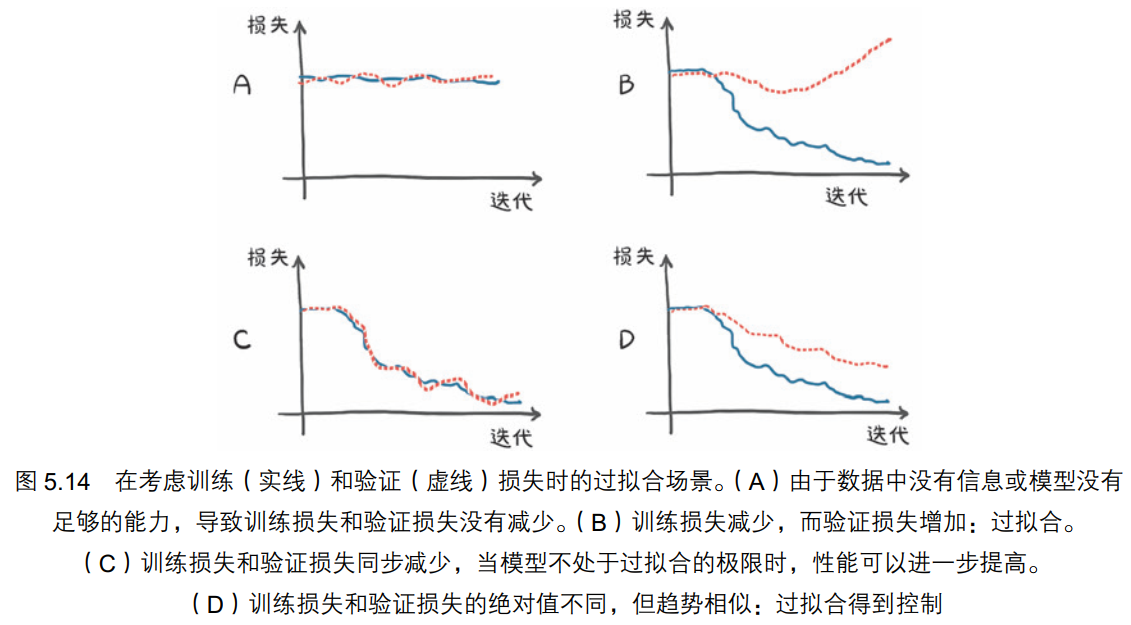

In [19]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        # 上下文管理器
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            # 检查在此块中输出的 requires_grad属性的值是否被强制设为 False
            assert val_loss.requires_grad == False
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

使用相关的 set_grad_enabled()，我们还可以根据一个布尔表达式设定代码运行时启用或禁用自动求导的条件，典型的条件是我们是在训练模式还是推理模式下运行。例如，我们可以定义一个 calc_forward()方法，它接收数据作为输入，根据一个布尔类型的参数决定 model()和 loss_fn()是否会进行自动求导。

In [20]:
def cal_c_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss